In [1]:
import pandas as pd

df = pd.read_csv(r'C:\Users\willf\OneDrive\Documents\amazon_reviews_us_Pet_Products_v1_00.tsv', sep='\t', encoding = 'utf-8', on_bad_lines='skip')



category = 'Pet Products'       
print(df.shape[0])
df.head()

2639853


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,28794885,REAKC26P07MDN,B00Q0K9604,510387886,(8-Pack) EZwhelp Belly Band/Wrap,Pet Products,5.0,0.0,0.0,N,Y,"A great purchase for ""dribbly"" dogs",Best belly bands on the market! These are a g...,2015-08-31
1,US,11488901,R3NU7OMZ4HQIEG,B00MBW5O9W,912374672,Warren Eckstein's Hugs & Kisses Vitamin Minera...,Pet Products,2.0,0.0,1.0,N,Y,My dogs love Hugs and Kisses,"My dogs love Hugs and Kisses. However, the la...",2015-08-31
2,US,43214993,R14QJW3XF8QO1P,B0084OHUIO,902215727,Tyson's True Chews Premium Jerky - 12 ounce Ch...,Pet Products,5.0,0.0,0.0,N,Y,I have been purchasing these for a long time. ...,I have been purchasing these for a long time. ...,2015-08-31
3,US,12835065,R2HB7AX0394ZGY,B001GS71K2,568880110,"Soft Side Pet Crate, Navy/Tan",Pet Products,5.0,0.0,0.0,N,Y,it is easy to open and close,"It is extremely well constructed, it is easy t...",2015-08-31
4,US,26334022,RGKMPDQGSAHR3,B004ABH1LG,692846826,"EliteField 3-Door Folding Soft Dog Crate, Indo...",Pet Products,5.0,0.0,0.0,N,Y,Dog crate,Worked really well. Very pleased with my purc...,2015-08-31


In [2]:
df_vine = df[df['vine']=='Y']
# df_vine.shape[0]
vine_prods = df_vine['product_id'].unique()
# len(vine_prods)

df_vine_prods = df[df['product_id'].isin(vine_prods)]
df_vp_vine_only = df_vine_prods[df_vine_prods['vine'] == 'Y']
df_vp_vine_ratings = df_vp_vine_only.groupby('product_id').agg({
    'star_rating': 'mean',
    'marketplace': 'count'
})
df_vp_vine_ratings.head()
df_vp_vr_enough_reviews = df_vp_vine_ratings[df_vp_vine_ratings['marketplace']>10]
df_vp_vr_enough_reviews.shape[0]

399

In [3]:
df_leashes = df[df['product_title'].str.contains("leash", case=False, na=False )]
df_leashes.shape[0]
df_leashes_products = df_leashes.groupby('product_id').agg({
    'marketplace': 'count',
    'star_rating': 'mean'
})

df_leashes_products_highrevs = df_leashes_products[df_leashes_products['marketplace']>100]


filtered_df_leashes = df_leashes[df_leashes['product_id'].isin(df_leashes_products_highrevs.index)]
unique_customer_ids = filtered_df_leashes['customer_id'].unique()
# formatted_customer_ids = ', '.join([f"{str(id)}" for id in unique_customer_ids])
# print(formatted_customer_ids)




In [4]:
df_leashes_VO = df_leashes[df_leashes['vine']=='Y']
df_leashes_VO['product_id'].nunique()

2

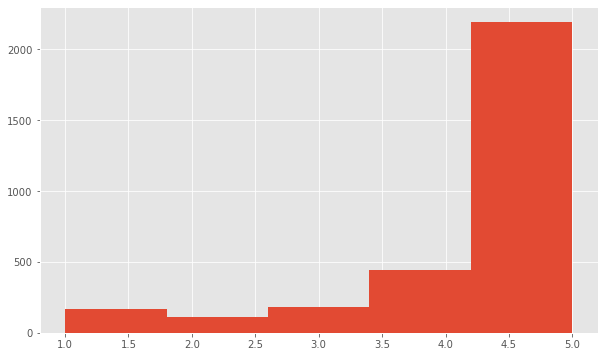

In [7]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
leashes_reviewer_counts = pd.read_csv(r"C:\Users\willf\OneDrive\Documents\NYDSA\Reviews Project\NYCDSA REVIEWS PROJECT\pet_leashes_reviewers.csv", names=["customer_id", "review_count"])
df_leash_rev_counts = pd.DataFrame(leashes_reviewer_counts)
df_leash_rev_counts.head()
df_freq_reviewers = df_leash_rev_counts[df_leash_rev_counts['review_count']>5]
frequent_reviewer_ids = df_freq_reviewers['customer_id'].tolist()

freq_filtered_leashes = filtered_df_leashes[filtered_df_leashes['customer_id'].isin(frequent_reviewer_ids)]

plt.figure(figsize=(10,6))
plt.hist(freq_filtered_leashes['star_rating'], bins=5)
plt.show()


In [8]:
filtered_df_leashes = filtered_df_leashes.copy()
filtered_df_leashes.loc[:, 'review_length'] = filtered_df_leashes['review_body'].fillna('').apply(len)

weight_frequent_reviewer = 250  # Example weight
weight_long_review = 1  # Example weight
weight_vine = 500 # Example weight

filtered_df_leashes.loc[:, 'weight'] = 1

filtered_df_leashes.loc[filtered_df_leashes['customer_id'].isin(frequent_reviewer_ids), 'weight'] *= weight_frequent_reviewer
filtered_df_leashes.loc[filtered_df_leashes['review_length'] > 250, 'weight'] *= weight_long_review
filtered_df_leashes.loc[filtered_df_leashes['vine'] == 'Y', 'weight'] *= weight_vine

aggregated = filtered_df_leashes.groupby('product_id').agg({
    'star_rating': 'mean',  # This gives the regular average rating
    'weight': 'sum',  # This gives the total weight for each product
    'review_length': 'count'  # This gives the number of reviews for each product
})

# Computing the weighted sum correctly for each product
aggregated['weighted_sum'] = filtered_df_leashes.groupby('product_id').apply(lambda x: (x['star_rating'] * x['weight']).sum())

# Compute the weighted average using the correct column for the sum of weights
aggregated['weighted_avg'] = aggregated['weighted_sum'] / aggregated['weight']


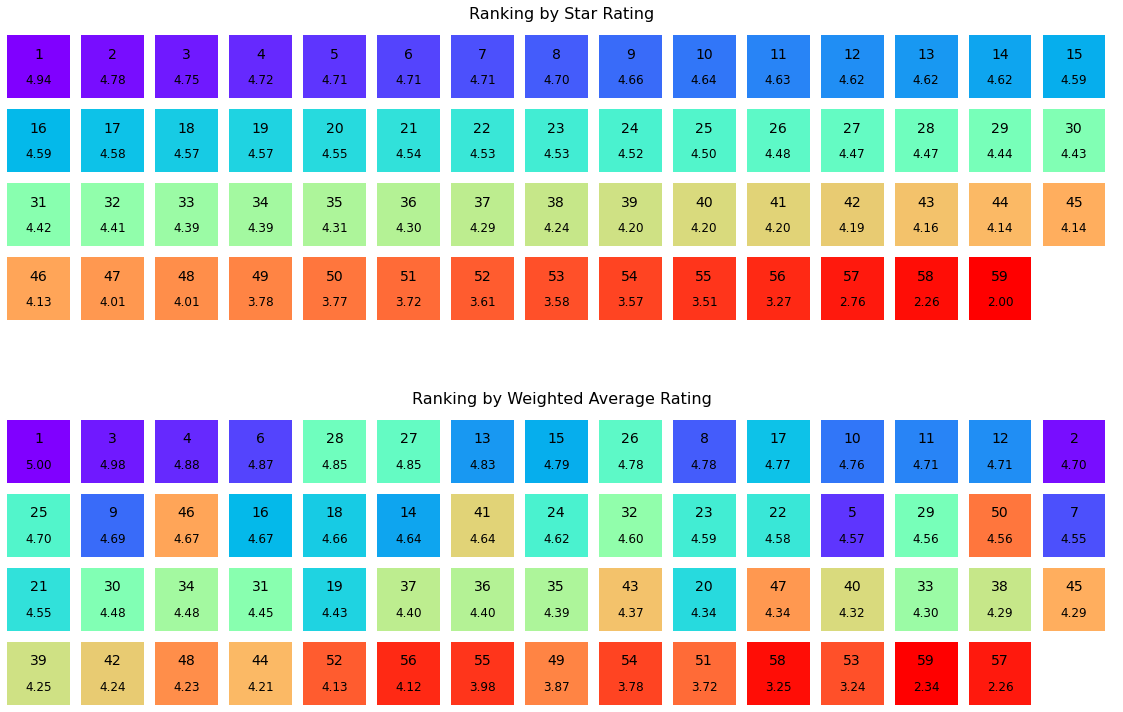

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assign a unique ID for each product based on 'star_rating' ranking
aggregated_sorted_by_star = aggregated.sort_values(by='star_rating', ascending=False).reset_index()
aggregated_sorted_by_star['product_rank_id'] = range(1, len(aggregated_sorted_by_star) + 1)

# Create a reversed color map to differentiate products
colors = plt.cm.rainbow(np.linspace(0, 1, len(aggregated_sorted_by_star)))

# Map of product_id to its unique color and rank ID
product_color_map = {product_id: color for product_id, color in zip(aggregated_sorted_by_star['product_id'], colors)}
product_rank_id_map = {product_id: rank_id for product_id, rank_id in zip(aggregated_sorted_by_star['product_id'], aggregated_sorted_by_star['product_rank_id'])}

# Sort by 'weighted_avg' for positioning in the right grid
aggregated_sorted_by_weighted_avg = aggregated.sort_values(by='weighted_avg', ascending=False).reset_index()

fig, axarr = plt.subplots(2, 1, figsize=(40, 10))

box_size = 1.7  # size of the box
spacing = 0.3  # space between boxes
num_rows = 4
num_cols = 15

# Grid for Star Rating
for idx, product_id in enumerate(aggregated_sorted_by_star['product_id']):
    row = num_rows - 1 - (idx // num_cols)
    col = idx % num_cols
    color = product_color_map[product_id]
    rank_id = product_rank_id_map[product_id]
    rating = aggregated.at[product_id, 'star_rating']
    
    axarr[0].add_patch(plt.Rectangle((col * (box_size + spacing), row * (box_size + spacing)), box_size, box_size, facecolor=color))
    axarr[0].text(col * (box_size + spacing) + box_size/2, row * (box_size + spacing) + 1.2, str(rank_id), ha='center', va='center', fontsize=14)
    axarr[0].text(col * (box_size + spacing) + box_size/2, row * (box_size + spacing) + 0.5, f"{rating:.2f}", ha='center', va='center', fontsize=12)

# Grid for Weighted Average Rating
for idx, product_id in enumerate(aggregated_sorted_by_weighted_avg['product_id']):
    row = num_rows - 1 - (idx // num_cols)
    col = idx % num_cols
    color = product_color_map[product_id]
    rank_id = product_rank_id_map[product_id]
    rating = aggregated.at[product_id, 'weighted_avg']
    
    axarr[1].add_patch(plt.Rectangle((col * (box_size + spacing), row * (box_size + spacing)), box_size, box_size, facecolor=color))
    axarr[1].text(col * (box_size + spacing) + box_size/2, row * (box_size + spacing) + 1.2, str(rank_id), ha='center', va='center', fontsize=14)
    axarr[1].text(col * (box_size + spacing) + box_size/2, row * (box_size + spacing) + 0.5, f"{rating:.2f}", ha='center', va='center', fontsize=12)

for ax in axarr:
    ax.set_xlim(0, num_cols * (box_size + spacing))
    ax.set_ylim(0, num_rows * (box_size + spacing))
    ax.set_aspect('equal')
    ax.axis('off')

axarr[0].set_title("Ranking by Star Rating", fontsize=16)
axarr[1].set_title("Ranking by Weighted Average Rating", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # adjust space between subplots
plt.show()


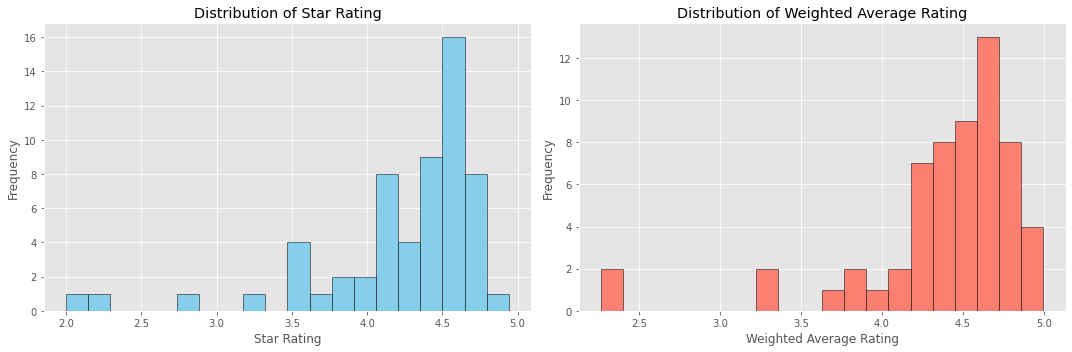

In [10]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))

# Histogram for Star Rating
axarr[0].hist(aggregated['star_rating'], bins=20, color='skyblue', edgecolor='black')
axarr[0].set_title('Distribution of Star Rating')
axarr[0].set_xlabel('Star Rating')
axarr[0].set_ylabel('Frequency')

# Histogram for Weighted Average Rating
axarr[1].hist(aggregated['weighted_avg'], bins=20, color='salmon', edgecolor='black')
axarr[1].set_title('Distribution of Weighted Average Rating')
axarr[1].set_xlabel('Weighted Average Rating')
axarr[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


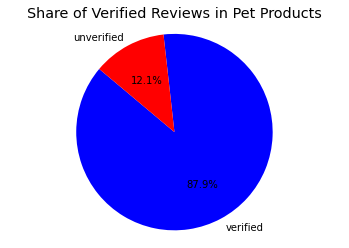

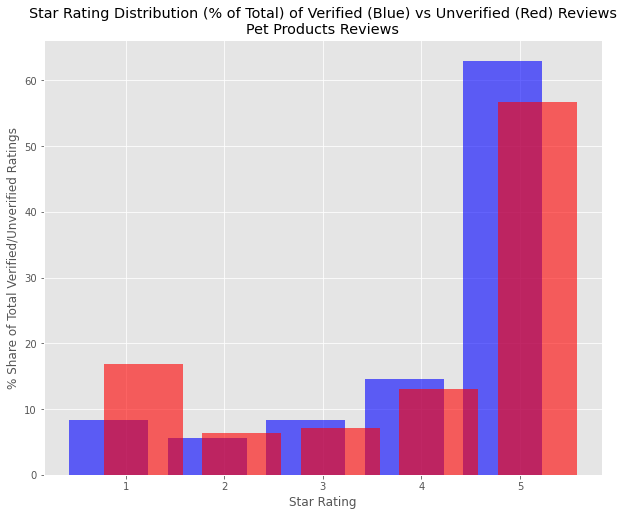

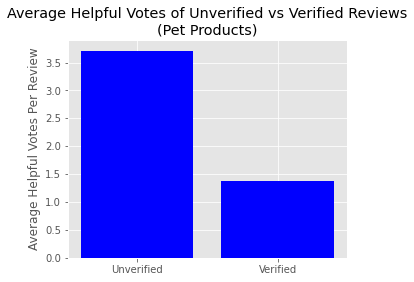

average star-rating bump for Pet Products - just from products with abnormally high # of unverified reviews - from removing unverified: 0.05211926337328317


In [11]:
# EDA of verified purchases. Are their reviews better distributed? Are they more helpful? Are they longer?
import numpy as np
import matplotlib.pyplot as plt

verified_only = df[df['verified_purchase']=='Y']
unverified_only = df[df['verified_purchase']=='N']

# Share of reviews that are verified


labels = ['verified', 'unverified']
sizes = [df[df['verified_purchase']=='Y']['review_id'].count(), df[df['verified_purchase']=='N']['review_id'].count()]
colors = ['blue', 'red']
plt.figure(facecolor='white')
plt.pie(sizes, labels = labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title(f'Share of Verified Reviews in {category}')
plt.axis('equal')
plt.style.use('ggplot')
plt.show()

# Now verified vs unverified star-rating distributions

star_ratings = np.arange(1,6)

total_verified = len(verified_only)
total_unverified = len(unverified_only)

verified_percentage = [(len(verified_only[verified_only['star_rating'] == rating]) / total_verified) * 100 for rating in star_ratings]
unverified_percentage = [(len(unverified_only[unverified_only['star_rating'] == rating]) / total_unverified) * 100 for rating in star_ratings]

width = 0.35
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(star_ratings - width/2, verified_percentage, alpha=0.6, color='blue', label='Verified')

ax.bar(star_ratings + width/2, unverified_percentage, alpha=0.6, color='red', label='Unverified')

ax.set_title(f"Star Rating Distribution (% of Total) of Verified (Blue) vs Unverified (Red) Reviews\n{category} Reviews")
ax.set_xticks(star_ratings)
ax.set_xlabel('Star Rating')
ax.set_ylabel('% Share of Total Verified/Unverified Ratings')

plt.show()

# Now helpfulness of verified vs unverified

ver_grouped = df.groupby('verified_purchase')['helpful_votes'].mean().reset_index()

plt.figure(figsize=(5,4))
plt.bar(ver_grouped['verified_purchase'], ver_grouped['helpful_votes'], color='blue')

plt.title(f"Average Helpful Votes of Unverified vs Verified Reviews\n({category})")
labels = ['Unverified', 'Verified']
plt.xticks(np.arange(len(labels)),labels)
plt.ylabel('Average Helpful Votes Per Review')

plt.show()

# Next, how would things change if unverified reviews were ignored? Maybe certain products have a large share of unverified reviews than others and these would have major agg score changes?

df_verified = df[df['verified_purchase'] == 'Y']
df_unverified = df[df['verified_purchase'] == 'N']

grouped_ver = df_verified.groupby(['product_id']).agg({
    'helpful_votes': 'sum',
    'review_id': 'count',
    'star_rating':'mean'
})

grouped_unver = df_unverified.groupby(['product_id']).agg({
    'helpful_votes': 'sum',
    'review_id': 'count',
    'star_rating':'mean'
})

grouped_ver['star_rating'] = grouped_ver['star_rating'].round(1)
grouped_unver['star_rating'] = grouped_unver['star_rating'].round(1)

df_prod_verstats = grouped_ver.merge(grouped_unver, on='product_id', how='outer', suffixes=('_Verified', '_Unverified'))

df_prod_verstats = df_prod_verstats.fillna(0)

df_prod_verstats['review_count'] = df_prod_verstats['review_id_Unverified'] + df_prod_verstats['review_id_Verified']
df_prod_verstats['total_helpful_votes'] = df_prod_verstats['helpful_votes_Unverified'] + df_prod_verstats['helpful_votes_Verified']
df_prod_verstats['share_verified'] = ((df_prod_verstats['review_id_Verified'] / df_prod_verstats['review_count'])*100).round(1)
df_prod_verstats['share_unverified'] = ((df_prod_verstats['review_id_Unverified'] / df_prod_verstats['review_count'])*100).round(1)
df_prod_verstats['share_helfpul_verified'] = ((df_prod_verstats['helpful_votes_Verified'] / df_prod_verstats['total_helpful_votes']) * 100).round(1)
df_prod_verstats['share_helfpul_unverified'] = ((df_prod_verstats['helpful_votes_Unverified'] / df_prod_verstats['total_helpful_votes']) * 100).round(1)

df_prod_verstats_filtered = df_prod_verstats[df_prod_verstats['review_count']>10]
mean_share_unverified = df_prod_verstats_filtered['share_unverified'].mean()
std_share_unverified = df_prod_verstats_filtered['share_unverified'].std()
threshold = mean_share_unverified + std_share_unverified

df_high_unver = df_prod_verstats_filtered[df_prod_verstats_filtered['share_unverified'] > threshold]

df_high_unver_star_bump = (df_high_unver['star_rating_Verified'] - df_high_unver['star_rating_Unverified']).mean()
print(f'average star-rating bump for {category} - just from products with abnormally high # of unverified reviews - from removing unverified: {df_high_unver_star_bump}')






c:\Users\willf\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


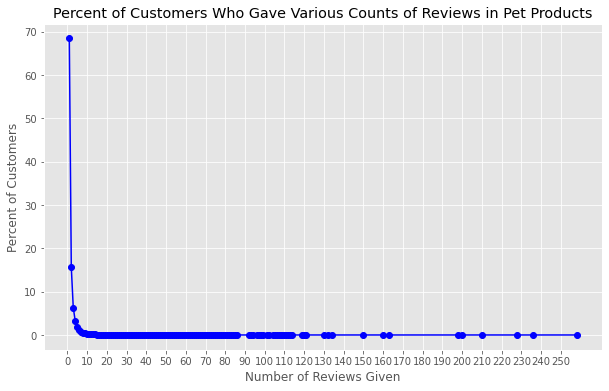

share of reviewers who gave more than 10 reviews in Pet Products: 1.33%


In [12]:
# Customer Trends. Customers with many reviews? If so, what is dispersion of scores? Etc.
import seaborn as sns
df_customer_trends = df.groupby('customer_id').agg({
    'helpful_votes': 'sum',
    'star_rating': 'mean',
    'marketplace': 'count'
}).reset_index().fillna(0)

# df_customer_trends.head(10)

df_custrend_hist = df_customer_trends.groupby('marketplace')['customer_id'].count().reset_index()

reviews = df_custrend_hist['marketplace']
customer_perc = (df_custrend_hist['customer_id']/df_custrend_hist['customer_id'].sum())*100

plt.figure(figsize=(10,6))
plt.plot(reviews, customer_perc, marker='o', linestyle='-', color='blue')

plt.xlabel('Number of Reviews Given')
plt.ylabel("Percent of Customers")
plt.title(f"Percent of Customers Who Gave Various Counts of Reviews in {category}")
plt.xticks(range(0,max(reviews)+1,10))
plt.style.use('ggplot')
plt.show()

print(f"share of reviewers who gave more than 10 reviews in {category}: {(((df_custrend_hist['marketplace']>10).sum()/df_custrend_hist['marketplace'].sum())*100).round(2)}%")


In [13]:
# Review dispersion per product. Do some have very low avg ratings? Are some more evenly mixed?
# start with a new dataframe with data grouped by product_id
df_prod_avgs = df.groupby('product_id').agg({
    'star_rating': 'mean',
    'helpful_votes': (lambda x: (x == 'Y').sum()),
    'vine': (lambda x: (x == 'Y').sum()),
    'verified_purchase': (lambda x: (x == 'Y').sum()),
    'marketplace': 'count'
}).reset_index()

df_prod_avgs = df_prod_avgs.rename(columns={'star_rating': 'avg_star_rating', 'marketplace': 'total_reviews'})
df_prod_avgs.head()

,product_id,avg_star_rating,helpful_votes,vine,verified_purchase,total_reviews
0,0310824230,5.000000,0,0,2,2
1,039480001X,4.755853,0,0,190,299
2,0615553605,4.142857,0,0,7,7
3,0684836483,2.714286,0,0,2,7
4,0761129804,3.000000,0,0,2,2


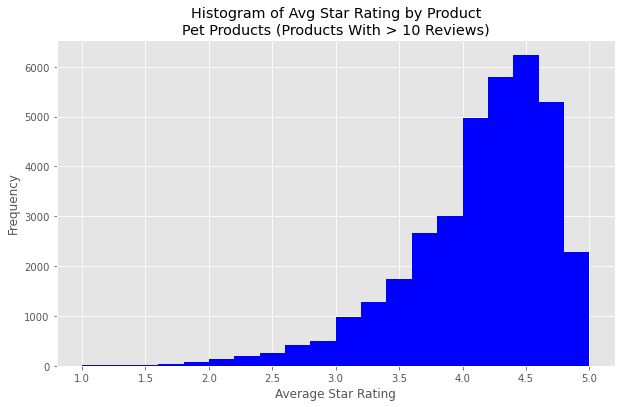

In [14]:
# first just a histogram of avg star ratings per product to see if it's any different from star ratings across all products
import seaborn as sns
df_prod_avgs_filt = df_prod_avgs[df_prod_avgs['total_reviews']>10]

plt.figure(figsize=(10,6))
plt.hist(df_prod_avgs_filt['avg_star_rating'], bins=20,color='blue')

plt.title(f'Histogram of Avg Star Rating by Product\n{category} (Products With > 10 Reviews)')
plt.xlabel('Average Star Rating')
plt.ylabel('Frequency')
plt.style.use("ggplot")

plt.show()

In [ ]:
# Now I want to look at the dispersion of star-ratings per product so I can see if all/most product have the same J curve or if there are more normal distribution
# Actually pretty sure this won't tell me anything even if some products do have a standard normal distribution

datetime64[ns]


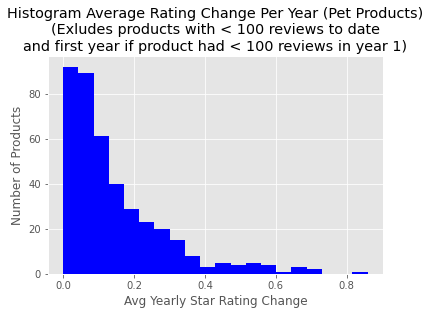

For Pet Products, excluding products with under 100 reviews and excluding the first year for products with < 100 reviews in their first year,
the absolute value mean change in average star-rating from year to year, per product is 0.16


In [15]:
# Look at how avg review scores change over time to see if there should be more weight on recent reviewsdf['review_date'].min())
df['review_date'] = pd.to_datetime(df['review_date'])

print(df['review_date'].dtype)

product_counts = df['product_id'].value_counts()
products_to_keep = product_counts[product_counts > 100].index.tolist()
df_filtered = df[df['product_id'].isin(products_to_keep)]

min_review_date = df_filtered.groupby('product_id')['review_date'].min()
one_yr_later = min_review_date + pd.DateOffset(years=1)

df_one_year_reviews = df_filtered[['product_id', 'review_date', 'review_id']]
df_one_year_reviews = df_one_year_reviews.merge(one_yr_later.reset_index(), on='product_id')
df_one_year_reviews.rename(columns={'review_date_x': 'review_date'}, inplace=True)

df_one_year_reviews = df_one_year_reviews[df_one_year_reviews['review_date'] <= df_one_year_reviews['review_date_y']]
count_first_yr = df_one_year_reviews.groupby('product_id')['review_id'].count()
products_under_100_reviews = count_first_yr[count_first_yr < 100].index
df_filtered = df_filtered[~df_filtered['product_id'].isin(products_under_100_reviews)]


df_date_365 = df_filtered.groupby(['product_id', pd.Grouper(key='review_date', freq='365D')]).agg({
    'marketplace': 'count',
    'star_rating': 'mean'
})
df_date_365 = df_date_365.rename(columns={'marketplace': 'total_reviews'})
df_date_365.reset_index(inplace=True)

df_date_365['rating_change'] = df_date_365.groupby('product_id')['star_rating'].diff().abs().fillna(0)

df_365_diff = df_date_365.groupby('product_id')['rating_change'].mean().reset_index()

plt.hist(df_365_diff['rating_change'], bins=20, color='blue')
plt.title(f'Histogram Average Rating Change Per Year ({category})\n(Exludes products with < 100 reviews to date\nand first year if product had < 100 reviews in year 1)')
plt.xlabel('Avg Yearly Star Rating Change')
plt.ylabel('Number of Products')
plt.show()

rounded_mean_change = round(df_date_365['rating_change'].abs().mean(), 2)
print(f'For {category}, excluding products with under 100 reviews and excluding the first year for products with < 100 reviews in their first year,\nthe absolute value mean change in average star-rating from year to year, per product is {rounded_mean_change}')

In [16]:
# See if review inflation happened over time. 
# product_counts = df['product_id'].value_counts()
# products_to_keep = product_counts[product_counts > 100].index.tolist()
# df_filtered = df[df['product_id'].isin(products_to_keep)]
# 
df['review_year'] = df['review_date'].dt.year

df_year_grouped = df.groupby('review_year').agg({
    'star_rating': 'mean',
    'review_id': 'count'
})

df_year_grouped.head(15)

,star_rating,review_id
review_year,,
1998.0,2.500000,2
1999.0,4.000000,13
2000.0,4.270270,37
2001.0,3.593750,32
2002.0,3.689655,116
2003.0,3.449477,287
2004.0,3.627737,685
2005.0,3.734518,1857
2006.0,3.896759,4659


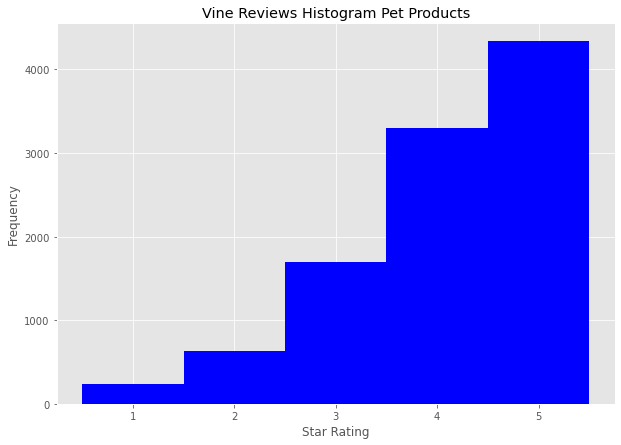

In [17]:
# Seeing if Vine reviews have a more standard distribution
import matplotlib.pyplot as plt

df_vine = df[df['vine']=='Y']
plt.figure(figsize=(10, 7))
plt.hist(df_vine['star_rating'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], range = (1,6), color='blue')

plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title(f"Vine Reviews Histogram {category}")

plt.show()

Text(0, 0.5, 'Average Helpful Votes')

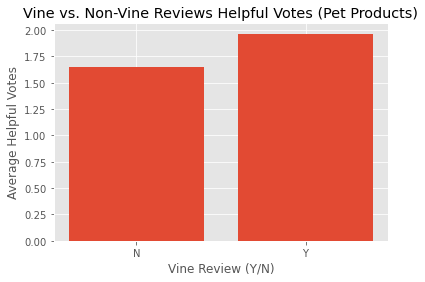

In [18]:
vine_grouped = df.groupby(df['vine'])['helpful_votes'].mean().reset_index()


plt.bar(vine_grouped['vine'],vine_grouped['helpful_votes'])
plt.title(f"Vine vs. Non-Vine Reviews Helpful Votes ({category})")
plt.xlabel("Vine Review (Y/N)")
plt.ylabel("Average Helpful Votes")

In [19]:
# EDA - There is only one marketplace in the Pet Products dataset
print(f"Marketplaces in {category}: {df['marketplace'].unique()} ")


Marketplaces in Pet Products: ['US'] 


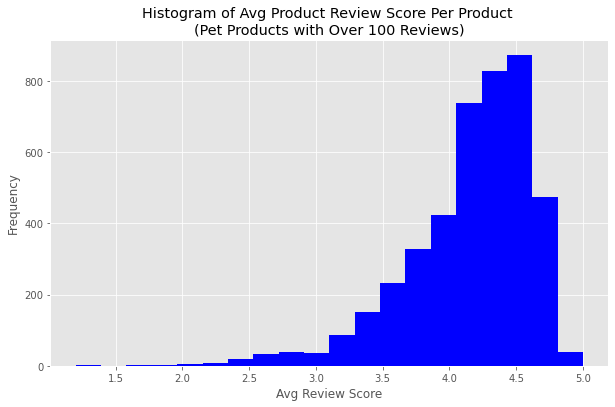

In [20]:
# EDA look at arithmetic average of reviews by grouping by product ID

product_review_avgs = df.groupby('product_id').agg({
    'star_rating': 'mean',
    'helpful_votes': 'sum',
    'review_id': 'count'
})

product_review_avgs = product_review_avgs.rename(columns={
    'star_rating': 'avg_rating',
    'review_id': 'total_reviews',
    'helpful_votes': 'total_helpful_votes'

})

product_review_avgs['avg_rating'] = product_review_avgs['avg_rating'].round(1)

prod_rev_avg_filtered = product_review_avgs[product_review_avgs['total_reviews']>100]

plt.figure(figsize=(10,6))

plt.hist(prod_rev_avg_filtered['avg_rating'], bins = 20, color='blue')
plt.title(f"Histogram of Avg Product Review Score Per Product \n({category} with Over 100 Reviews)")
plt.xlabel("Avg Review Score")
plt.ylabel("Frequency")

plt.show()


In [21]:
verified_count = df[df['verified_purchase']=='Y']['review_id'].count()
unverified_count = df[df['verified_purchase']=='N']['review_id'].count()

print("Verified Count:", verified_count)
print("Unverified Count:", unverified_count)


Verified Count: 2320182
Unverified Count: 319670


In [22]:
product_counts = df['product_id'].value_counts()

avg_count = product_counts.mean()

products_to_keep = product_counts[product_counts > 100].index.tolist()
df_filtered = df[df['product_id'].isin(products_to_keep)]
df_filtered['product_id'].nunique()

4323

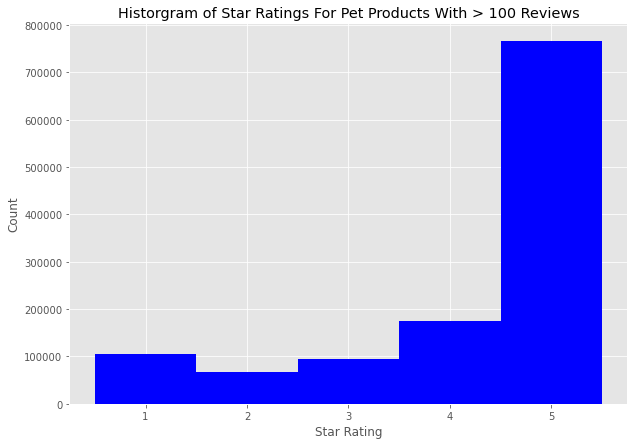

In [23]:
# Getting initial histogram of star ratings of all products with more than 200 reviews

import matplotlib.pyplot as plt 
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
plt.figure(figsize=(10, 7))

plt.hist(df_filtered['star_rating'], bins=bins, range=(1,6), color='blue')

plt.title(f'Historgram of Star Ratings For {category} With > 100 Reviews')
plt.xlabel('Star Rating')
plt.ylabel ('Count')

plt.xticks([1,2,3,4,5])

plt.show()

1208106


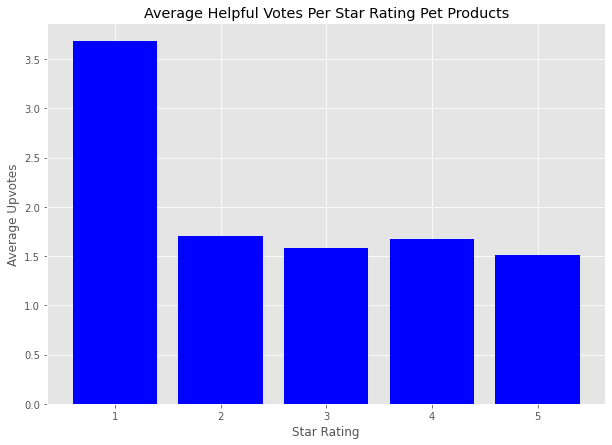

In [ ]:
# Get histogram of upvotes per star-rating

df_grouped = df_filtered.groupby(['star_rating'])['helpful_votes'].mean().reset_index()
print(df_filtered.shape[0])

plt.figure(figsize=(10, 7))
plt.bar(df_grouped['star_rating'], df_grouped['helpful_votes'], color='blue', align='center')


plt.title(f'Average Helpful Votes Per Star Rating {category}')
plt.xlabel('Star Rating')
plt.ylabel ('Average Upvotes')

plt.xticks([1,2,3,4,5])

plt.show()

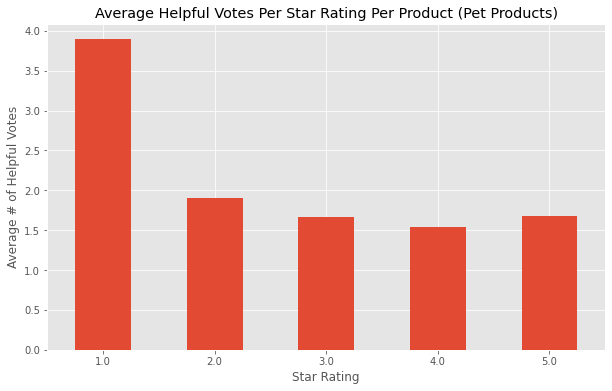

In [25]:
# Get bar chart of upvotes per star-rating, per product

from matplotlib.ticker import FuncFormatter

df_perc = df_filtered.copy()
# print (df_perc)

df_perc['count_of_star_rating'] = df_perc.groupby(['product_id','star_rating'])['review_id'].transform('count')
df_perc['rating_sum_helpful_votes'] = df_perc.groupby(['product_id','star_rating'])['helpful_votes'].transform('sum')
df_perc['helpful_votes_per_star_rating'] = df_perc.apply(lambda row: (row['rating_sum_helpful_votes']/row['count_of_star_rating']) if row['count_of_star_rating'] !=0 else None, axis=1)

result = df_perc.groupby(['product_id', 'star_rating'])[['product_id', 'star_rating', 'count_of_star_rating', 'rating_sum_helpful_votes','helpful_votes_per_star_rating']].first()
# print(result.head(20))

result = result.rename(columns={'star_rating': 'alias_star_rating'})


df_avg_perc = result.groupby('alias_star_rating')['helpful_votes_per_star_rating'].mean()
# print(df_avg_perc.head(20))

plt.figure(figsize=(10, 6))
df_avg_perc.plot(kind='bar')

plt.title(f'Average Helpful Votes Per Star Rating Per Product ({category})')
plt.xlabel('Star Rating')
plt.ylabel ('Average # of Helpful Votes')

plt.xticks(rotation = 0)
plt.show()



In [26]:
df_filtered[df_filtered['star_rating'] == 1]['helpful_votes'].sum()

384867.0

In [27]:
# Next create a new column that has the length of the review text
df_f_copy = df_filtered.copy()

df_f_copy['review_length'] = df_filtered['review_body'].apply(lambda x: len(x) if isinstance(x,str) else None)

# print(df_f_copy.head(30))

In [28]:
# Next calculate the correlation between the length of the review and the number of helpful votes it receives

import numpy as np

df_f_copy['review_length'] = df_f_copy['review_length'].astype(float)
df_f_copy['helpful_votes'] = df_f_copy['helpful_votes'].astype(float)


correlation = df_f_copy['review_length'].corr(df_f_copy['helpful_votes'])
print(f"Correlation coefficient between review length and helpful votes {category}: {correlation:.2f}")

Correlation coefficient between review length and helpful votes Pet Products: 0.20


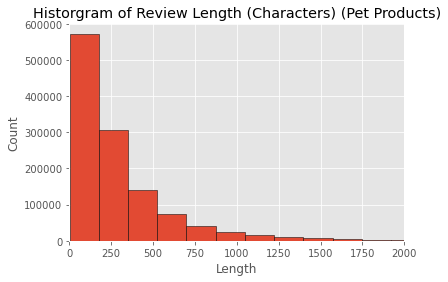

In [29]:
# Do very short reviews ever get helpful votes? How often? Start with histogram of review length

import matplotlib.pyplot as plt

plt.hist(df_f_copy['review_length'], bins=200, edgecolor='black')

plt.title(f'Historgram of Review Length (Characters) ({category})')
plt.xlabel('Length')
plt.ylabel ('Count')

plt.xlim(0,2000)

# xticks = [200 * i for i in range(len(df_f_copy) // 200 + 1)]
# plt.xticks(xticks)
# 
# plt.xlim(0,2000)
# 
plt.show()

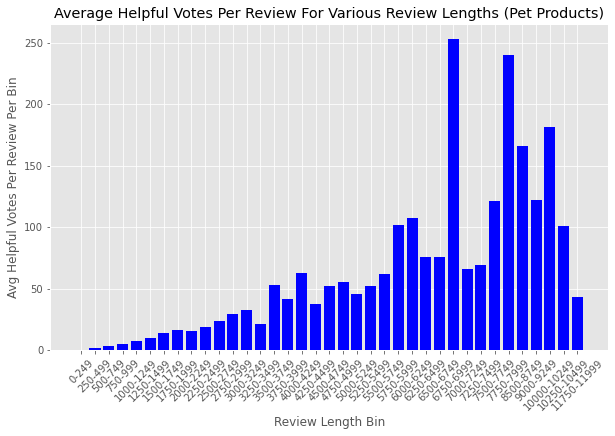

In [30]:
# Get bar chart of upvotes bin of review length


from matplotlib.ticker import FuncFormatter

df_length = df_f_copy.copy()

df_length['review_length'].fillna(0, inplace=True)
df_length['review_length'].replace(0,1,inplace=True)

# print(df_length.head(30))

df_length['review_length'] = df_length['review_length'].astype(int)

bins = range(0,df_length['review_length'].max() + 251, 250)
labels = [f'{i}-{i + 249}' for i in bins[:-1]]
df_length['review_length_bin'] = pd.cut(df_length['review_length'], bins=bins, labels=labels)

grouped = df_length.groupby('review_length_bin').agg({'review_length': 'count', 'helpful_votes': 'sum'}).reset_index()
grouped['helpful_votes_per_review'] =  grouped['helpful_votes']/ grouped['review_length']
# print(grouped)

grouped_filtered = grouped[grouped['review_length']>=10]

plt.figure(figsize=(10, 6))
plt.bar(grouped_filtered['review_length_bin'], grouped_filtered['helpful_votes_per_review'],color = 'blue')



plt.title(f'Average Helpful Votes Per Review For Various Review Lengths ({category})')
plt.xlabel('Review Length Bin')
plt.ylabel ('Avg Helpful Votes Per Review Per Bin')


plt.xticks(rotation = 45)

plt.style.use("ggplot")

plt.show()

# So we see that customers don't find short reviews very helpful and that suggests they should not have as much weight

<function matplotlib.pyplot.show(close=None, block=None)>

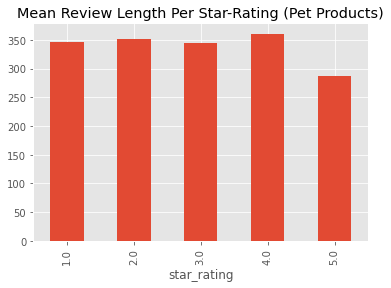

In [31]:
# Do some star-ratings tend to have longer reviews than others?

mean_review_length = df_f_copy.groupby(['star_rating'])['review_length'].mean()

mean_review_length.plot(kind = 'bar')
plt.title(f"Mean Review Length Per Star-Rating ({category})")
plt.show


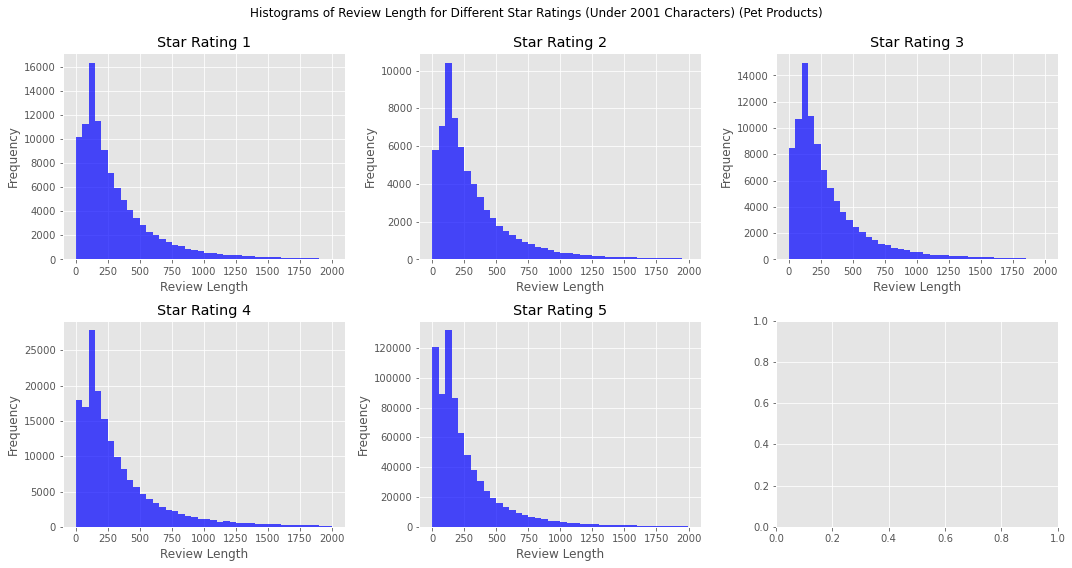

In [32]:
# Scholars say that the J-shaped curve that most online reviews take is due to a selection bias where buyers who wanted/bought a product are more likely to be happy with it
# But I believe that a lot of the 5-stars in the j-shape are due to customers being asked for reviews and leaving a 5-star because nothing is wrong with their purchase.
# To support this, I want to look at the length of 5-star reviews, with the hypothesis that they are shorter on average than other stars.

mean_review_length = df_f_copy.groupby(['star_rating'])['review_length'].mean()

# mean_review_length.plot(kind = 'bar')
# plt.show

# Let's see histogram of review lengths for each star-rating

df_f_fives = df_length[(df_length['star_rating'] == 5) & (df_length['review_length'] < 2000)]
df_f_fours = df_length[(df_length['star_rating'] == 4) & (df_length['review_length'] < 2000)]
df_f_threes = df_length[(df_length['star_rating'] == 3) & (df_length['review_length'] < 2000)]
df_f_twos = df_length[(df_length['star_rating'] == 2) & (df_length['review_length'] < 2000)]
df_f_ones = df_length[(df_length['star_rating'] == 1) & (df_length['review_length'] < 2000)]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f'Histograms of Review Length for Different Star Ratings (Under 2001 Characters) ({category})')

dataframes = [df_f_ones, df_f_twos, df_f_threes, df_f_fours, df_f_fives]
star_ratings = [1,2,3,4,5]

for i, df in enumerate(dataframes):
    row, col = i // 3, i % 3
    ax = axes[row,col]
    ax.hist(df['review_length'], bins=40, color='blue', alpha=0.7)
    ax.set_title(f'Star Rating {star_ratings[i]}')
    ax.set_xlabel("Review Length")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

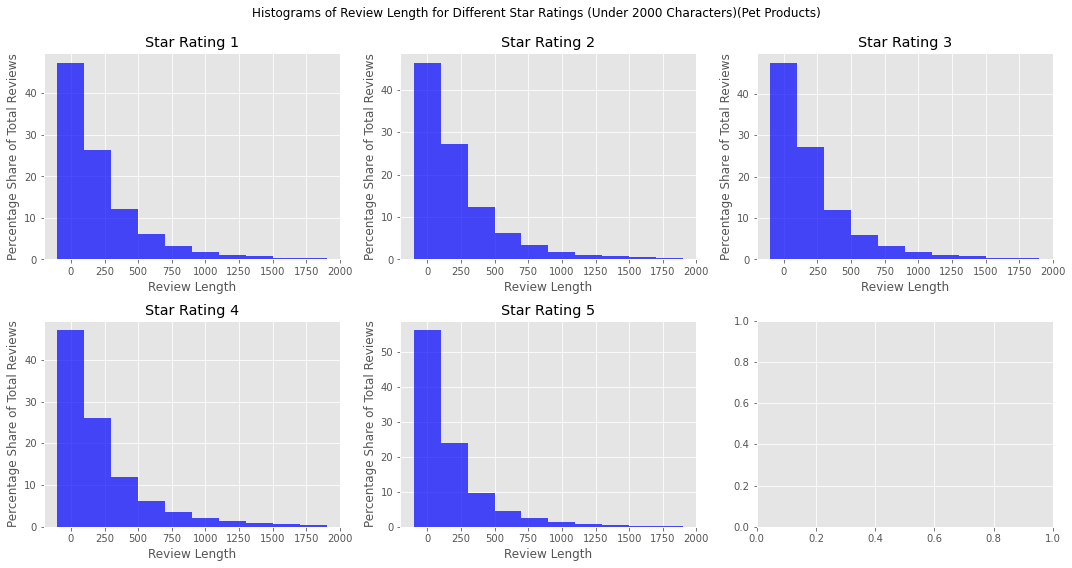

In [33]:
import matplotlib.pyplot as plt

# Filter the DataFrame to select only reviews with lengths under 2000 characters
df_filtered = df_length[df_length['review_length'] < 2000]

# Create subplots with a grid layout for each star rating
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f'Histograms of Review Length for Different Star Ratings (Under 2000 Characters)({category})')

# DataFrames for different star ratings
dataframes = [df_f_ones, df_f_twos, df_f_threes, df_f_fours, df_f_fives]
star_ratings = [1, 2, 3, 4, 5]

for i, df in enumerate(dataframes):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    # Calculate the histogram of review lengths
    review_lengths = df['review_length']
    bins = 10
    hist, bin_edges = np.histogram(review_lengths, bins=bins, range=(0, 2000))

    # Calculate the percentage share of reviews in each bin
    total_reviews_for_rating = len(df)
    share = (hist / total_reviews_for_rating) * 100

    # Plot the histogram
    ax.bar(bin_edges[:-1], share, width=bin_edges[1] - bin_edges[0], color='blue', alpha=0.7)
    ax.set_title(f'Star Rating {star_ratings[i]}')
    ax.set_xlabel('Review Length')
    ax.set_ylabel('Percentage Share of Total Reviews')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


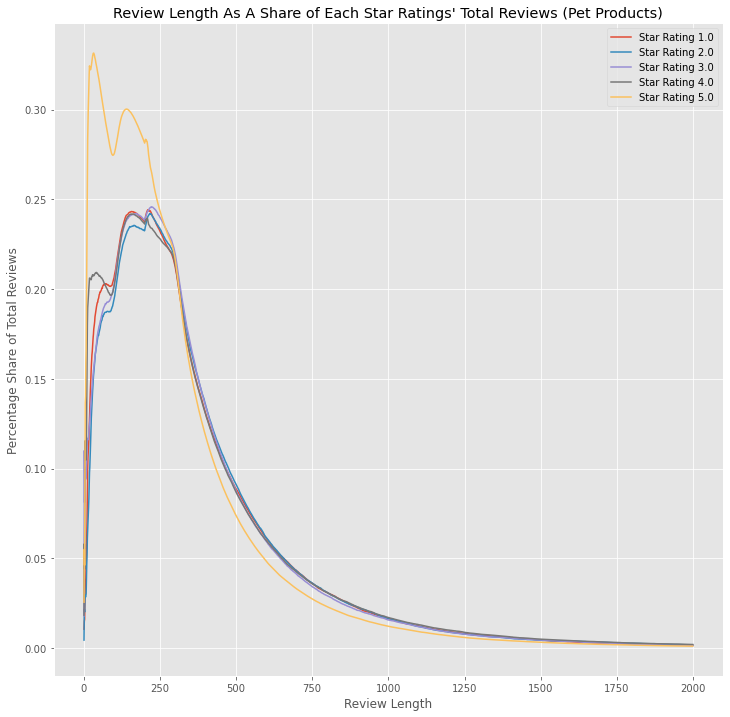

In [34]:
# Let's try to look at the histograms together as lines

import matplotlib.pyplot as plt

# Filter the DataFrame to select only reviews with lengths under 2000 characters
df_filtered = df_length[df_length['review_length'] < 2000]

# Group the filtered DataFrame by 'star_rating' and calculate the total count of reviews for each star rating
total_reviews = df_filtered['star_rating'].value_counts().sort_index()

# Group the filtered DataFrame by 'star_rating' and calculate the count of each review length
grouped_data = df_filtered.groupby('star_rating')['review_length'].value_counts().unstack().fillna(0)

# Plot line charts for each star rating as a percentage share of total reviews

plt.figure(figsize=(12,12))
for star_rating in grouped_data.index:
    review_lengths = grouped_data.loc[star_rating]
    share = (review_lengths / total_reviews[star_rating]) * 100  # Calculate the percentage share
    smoothed_share = share.rolling(window=200,min_periods = 1).mean()
    plt.plot(smoothed_share.index, smoothed_share.values, label=f'Star Rating {star_rating}')


plt.xlabel('Review Length')
plt.ylabel('Percentage Share of Total Reviews')
plt.title(f"Review Length As A Share of Each Star Ratings' Total Reviews ({category})")
plt.legend()
plt.show()



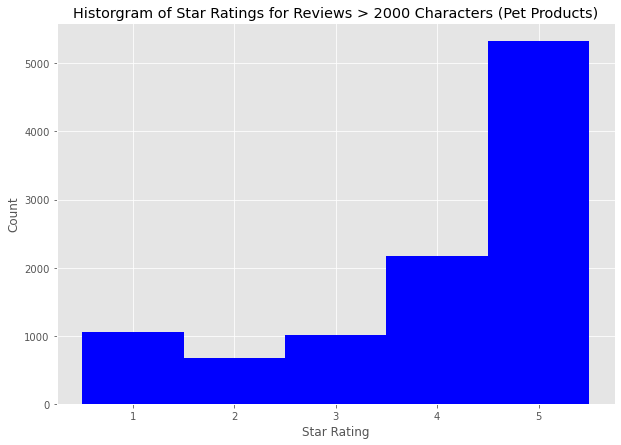

In [35]:
# What if I just look at "long" reviews. What is the star-rating distribution like then?

df_long = df_length[df_length['review_length']>2000]

bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
plt.figure(figsize=(10, 7))

plt.hist(df_long['star_rating'], bins=bins, range=(1,6), color='blue')

plt.title(f'Historgram of Star Ratings for Reviews > 2000 Characters ({category})')
plt.xlabel('Star Rating')
plt.ylabel ('Count')

plt.xticks([1,2,3,4,5])
plt.style.use("ggplot")

plt.show()

In [36]:

# shifting to looking at distribution of average rating scores on a search page and how those might look normalized

# first import the json and create a dataframe
import json

with open(r"C:\Users\willf\OneDrive\Documents\NYDSA\Reviews Project\retractabel_dog_leash_search_results.json",'r') as leash_json:
    data = json.load(leash_json)


positions = []
titles = []
asins = []
ratings = []
total_ratings = []
images = []

for item in data['search_results']:
    position = item.get('position', None)
    title = item.get('title',None)
    asin = item.get('asin', None)
    agg_rating = item.get('rating',None)
    ratings_total = item.get('ratings_total', None)
    image = item.get('image',None)
    
    positions.append(position)
    titles.append(title)
    asins.append(asin)
    ratings.append(agg_rating)
    total_ratings.append(ratings_total)
    images.append(image)

df = pd.DataFrame({
    'position': positions,
    'title': titles,
    'asin': asins,
    'agg_rating': ratings,
    'ratings_total': total_ratings,
    'image': images

})



(0.0, 5.0)

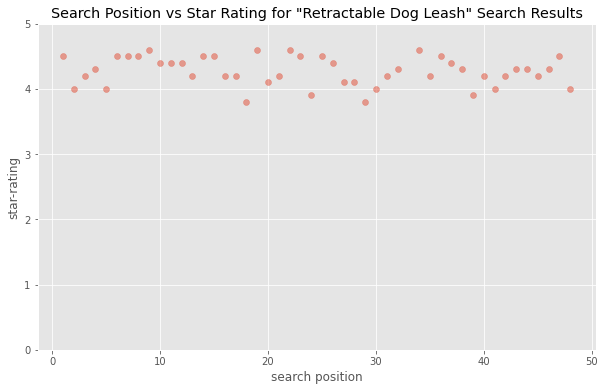

In [37]:
# Here we see a scatter plot showing that all ratings on page one of search results are high and also that ratings alone don't have much to do with search rank

plt.figure(figsize=(10,6))

plt.scatter(df['position'], df['agg_rating'], alpha=0.5)

plt.title('Search Position vs Star Rating for "Retractable Dog Leash" Search Results')
plt.xlabel('search position')
plt.ylabel('star-rating')
plt.ylim(0,5)

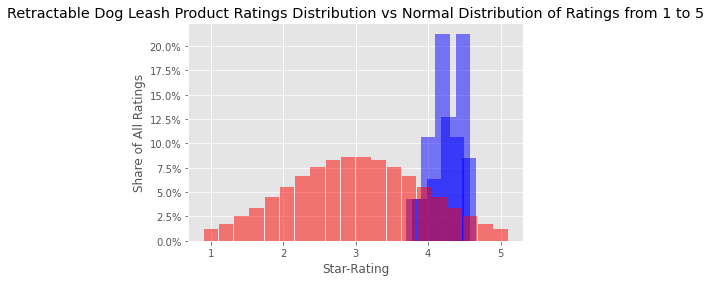

In [38]:
# Now I want to show the distribution of these ratings vs a standard normal distribution
# The idea here is that studies have shown that a low dispersion of review scores makes it hard for customers to interpret them. A wider dispersion would improve things.
from scipy.stats import norm
import matplotlib.ticker as mtick
import seaborn as sns

ratings = df['agg_rating'].dropna()

hist, bin_edges = np.histogram(ratings, bins=20, density=True)
hist /= hist.sum()
# plt.hist(ratings,bins=15,density=True, alpha = 0.6, label='Rating Distribution')

x = np.linspace(1,5,20)

mu, std = 3,1

pdf = norm.pdf(x,mu,std)
pdf /= pdf.sum()

hist_percent = hist * 100
pdf_percent = pdf * 100

plt.bar(bin_edges[:-1], hist_percent, width=0.2, alpha=0.5, color='blue', label = 'Rating Distribution')
plt.bar(x, pdf_percent, width=0.2, alpha=0.5, color='red', label = 'Standard Normal Distribution 1-5')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Retractable Dog Leash Product Ratings Distribution vs Normal Distribution of Ratings from 1 to 5')
plt.xlabel('Star-Rating')
plt.ylabel('Share of All Ratings')
plt.style.use("ggplot")
plt.show()

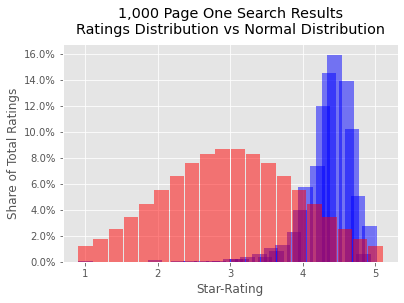

In [39]:
df_searches = pd.read_csv(r"C:\Users\willf\OneDrive\Documents\NYDSA\Reviews Project\searches_df.csv")

searches_ratings = df_searches['rating']
search_ratings = searches_ratings.dropna()

hist, bin_edges = np.histogram(search_ratings, bins=50, density=True)
hist /= hist.sum()

x = np.linspace(1,5,20)

mu, std = 3,1

pdf = norm.pdf(x,mu,std)
pdf /= pdf.sum()

hist_percent = hist * 100
pdf_percent = pdf * 100

plt.bar(bin_edges[:-1], hist_percent, width=0.2, alpha=0.5, color='blue', label = 'Rating Distribution')
plt.bar(x, pdf_percent, width=0.2, alpha=0.5, color='red', label = 'Standard Normal Distribution 1-5')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title("1,000 Page One Search Results\nRatings Distribution vs Normal Distribution", y=1.02)
plt.xlabel('Star-Rating')
plt.ylabel('Share of Total Ratings')
plt.style.use("ggplot")
plt.show()

In [ ]:
# Next I want to see how much Amazon actually manipulates the review score vs a plain mathematical average
# The idea here is to see how much Amazon is doing to "improve" the usefulness of reviews to customers by increasing the dispersion, weighting things like 1-star reviews higher
# to reflect the higher importance customers put on them and so on.

# Unfortunately neither dataset I've used so far has the aggregated review score from Amazon so I have to use a third dataset here: https://www.kaggle.com/datasets/grikomsn/amazon-cell-phones-reviews

import csv
import pandas as pd


# file_path_reviews = "C:\Users\willf\OneDrive\Documents\NYDSA\Reviews Project\archive (3)\20191226-reviews.csv"

with open(r"C:\Users\willf\OneDrive\Documents\NYDSA\Reviews Project\archive (3)\20191226-items.csv", 'r', newline='') as meta_file:
    df_meta = pd.read_csv(meta_file)

# print(df_meta.head())

with open(r"C:\Users\willf\OneDrive\Documents\NYDSA\Reviews Project\archive (3)\20191226-reviews.csv", 'r', newline='') as review_file:
    df_reviews = pd.read_csv(review_file)

# df_reviews.head()

df_meta.shape[0]  

720

In [ ]:
df_merged = df_reviews.merge(df_meta, on='asin', how='left')
df_merged.shape[0]

67986

In [ ]:
df_avgs = df_merged.groupby('asin').agg({'rating_x': 'mean', 'rating_y': 'first'}).reset_index()
df_avgs.shape[0]

720

NameError: name 'df_avgs' is not defined

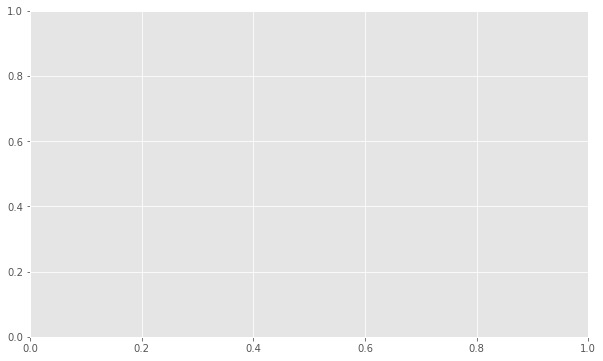

In [40]:
# Here we can see Amazon's weighted avg star-rating for products vs the regular arithmetic mean. They aren't far apart.
import matplotlib.pyplot as plt
y_max = 200
y_min = 0

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(df_avgs['rating_x'],bins=10, alpha=0.6, color='blue')

ax.hist(df_avgs['rating_y'], bins=10, alpha=0.6, color ='red')
ax.set_title("Amazon's Weighted Avg Star Rating (Red) vs Regular Arithmetic Avg (Blue)")
ax.set_ylim(y_min, y_max)
plt.show()

NameError: name 'df_avgs' is not defined

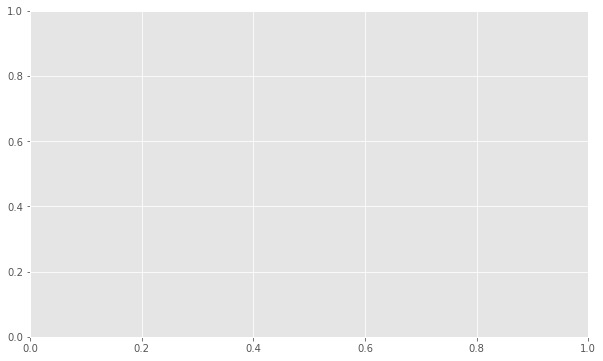

In [41]:
import matplotlib.pyplot as plt

# Assuming df_avgs is your DataFrame with 'rating_x' and 'rating_y' columns.
fig, ax = plt.subplots(figsize=(10, 6))

# Creating boxplot
ax.boxplot([df_avgs['rating_x'], df_avgs['rating_y']], labels=['Weighted Avg Star Rating', 'Regular Arithmetic Avg'])

# Setting the titles
ax.set_title("Comparison of Amazon's Weighted Avg Star Rating vs Regular Arithmetic Avg")

# Adding grid
ax.yaxis.grid(True)

plt.show()


NameError: name 'df_avgs' is not defined

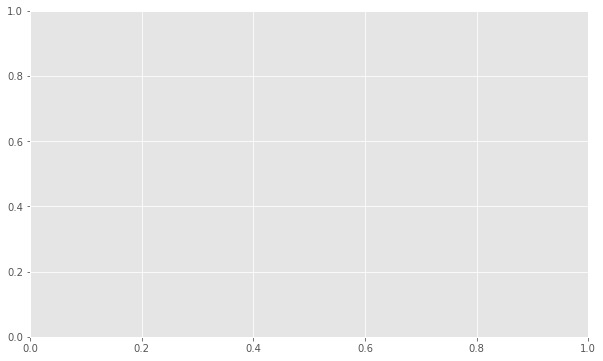

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.violinplot([df_avgs['rating_x'], df_avgs['rating_y']], showmeans=True)

# Setting labels for each plot
ax.set_xticks([1, 2])
ax.set_xticklabels(['Weighted Avg Star Rating', 'Regular Arithmetic Avg'])

# Setting the title
ax.set_title("Comparison of Amazon's Weighted Avg Star Rating vs Regular Arithmetic Avg")

# Adding grid
ax.yaxis.grid(True)

plt.show()

NameError: name 'df_avgs' is not defined

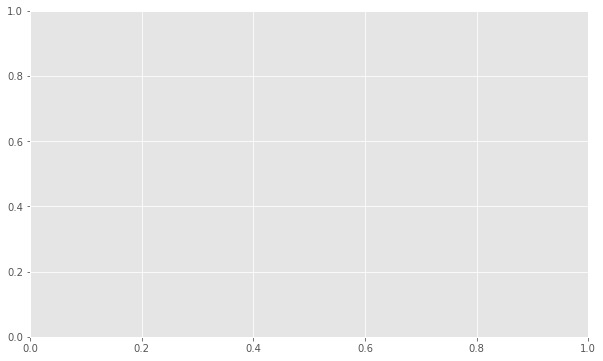

In [43]:
import matplotlib.pyplot as plt

# Assuming df_avgs is your DataFrame and it contains 'rating_x' for the weighted average
# and 'rating_y' for the arithmetic average.
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot where x and y are your two average ratings.
ax.scatter(df_avgs['rating_x'], df_avgs['rating_y'], alpha=0.5)

# Now, let's plot the y=x line which will serve as a reference.
max_rating = max(df_avgs['rating_x'].max(), df_avgs['rating_y'].max())
min_rating = min(df_avgs['rating_x'].min(), df_avgs['rating_y'].min())
ax.plot([min_rating, max_rating], [min_rating, max_rating], 'k--', lw=2)  # Black dashed line for y=x.

ax.set_xlabel('Weighted Avg Star Rating')
ax.set_ylabel('Regular Arithmetic Avg')
ax.set_title("Scatter Plot Comparison of Amazon's Weighted Avg Star Rating vs Regular Arithmetic Avg")
ax.grid(True)

plt.show()


NameError: name 'df_avgs' is not defined

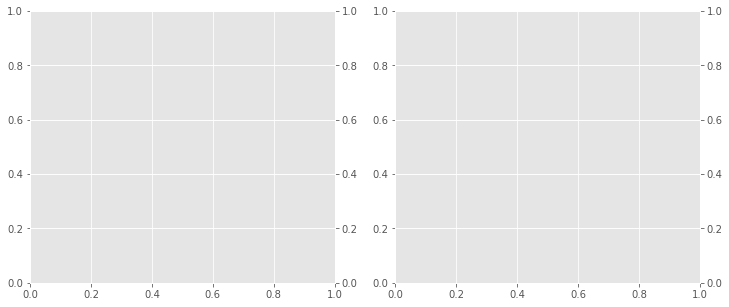

In [44]:
# Now just for clarity, I want to put the above side by side but each with an overlaid standard normal distribution from 1-5

# first I'll set up the side by side

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1_right = ax1.twinx()
ax2_right = ax2.twinx()


mean = 3
spread = 1

x = np.linspace(1,5,1000)
pdf = norm.pdf(x, mean, spread)

hist_x, bin_edges_x = np.histogram(df_avgs['rating_x'], bins=20, density=True)
bin_centers_x = (bin_edges_x[1:] + bin_edges_x[:-1]) / 2
# hist_std_normal_x = np.interp(bin_centers_x, x, pdf)

ax1.hist(df_avgs['rating_x'], bins = 20, color = 'blue', alpha=0.6)
ax1.set_title('Histogram of Arithmetic Mean of Star Ratings Per Product')
ax1.set_xlabel('Star Rating')
ax1.set_ylabel ('Frequency')
ax1.set_ylim(0,150)


ax1_right.plot(x, pdf, color='green', label='Standard Normal Distribution' )
ax1_right.set_ylim(0,0.6)


hist_y, bin_edges_y = np.histogram(df_avgs['rating_y'], bins=20, density=True)
bin_centers_y = (bin_edges_y[1:] + bin_edges_y[:-1]) / 2

ax2.hist(df_avgs['rating_y'], bins = 20, color = 'red', alpha=0.6)
ax2.set_title('Histogram of Amazon Weighted Star Ratings Per Product')
ax2.set_xlabel('Star Rating')
ax2.set_ylabel ('Frequency')
ax2.set_ylim(0,150)

ax2_right.plot(x, pdf, color='green', label='Standard Normal Distribution' )
ax2_right.set_ylim(0,0.6)


plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df_headphones = pd.read_csv(r"C:\Users\willf\OneDrive\Documents\NYDSA\Reviews Project\df_scrape.csv")
df_headphones.head()

,Unnamed: 0,CR_Category,Product_Name,Product_Link,Amazon_Link,ASIN,Walmart,Target,Best Buy,CR_Score,...,Four_star_Percentage,Four_star_Count,Three_star_Percentage,Three_star_Count,Two_star_Percentage,Two_star_Count,One_star_Percentage,One_star_Count,amz_rating_adj,Bins
0,0,Noise Cancelling Headphones,Bose Noise Cancelling Headphones 700,https://www.consumerreports.org/electronics-co...,https://www.amazon.com/dp/B07Q9MJKBV?tag=dprmd...,B07Q9MJKBV,4.2,4.2,4.6,87,...,11,3754,4,1365,3,1023,5,1706,90,10.0
1,1,Noise Cancelling Headphones,Bowers & Wilkins PX7 S2,https://www.consumerreports.org/electronics-co...,https://www.amazon.com/dp/B09ZXXYRKY?tag=dprmd...,B09ZXXYRKY,NaN,NaN,NaN,81,...,13,247,7,133,7,133,7,133,86,20.0
2,2,Noise Cancelling Headphones,Apple AirPods Max,https://www.consumerreports.org/electronics-co...,https://www.amazon.com/dp/B08PZHYWJS?tag=dprmd...,B08PZHYWJS,NaN,NaN,NaN,81,...,7,934,3,400,2,267,4,534,92,30.0
3,3,Noise Cancelling Headphones,Dyson Zone,https://www.consumerreports.org/electronics-co...,https://www.amazon.com/dp/B0C3ND6PXG?tag=dprmd...,B0C3ND6PXG,NaN,NaN,NaN,78,...,35,8,23,5,0,0,7,1,78,40.0
4,4,Noise Cancelling Headphones,Bose QuietComfort 45,https://www.consumerreports.org/electronics-co...,https://www.amazon.com/dp/B098FKXT8L?tag=dprmd...,B098FKXT8L,NaN,NaN,NaN,77,...,9,1662,3,554,2,369,4,738,92,50.0


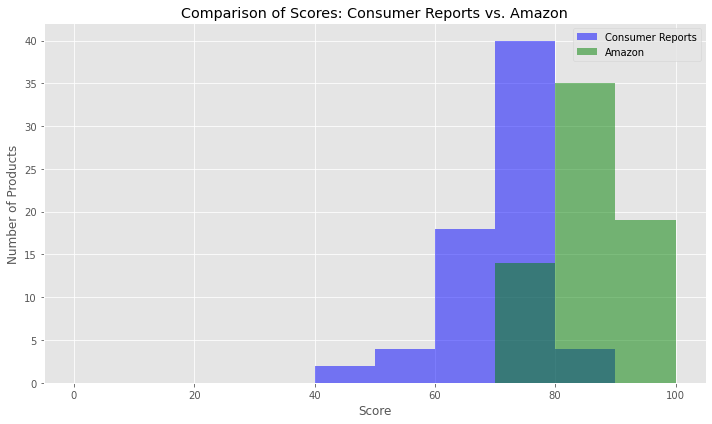

In [ ]:
bins = np.linspace(0, 100, 11)  # This creates bins [0, 10, 20, ..., 100]
plt.figure(figsize=(10,6))
plt.hist(df_headphones['CR_Score'], bins, alpha=0.5, label='Consumer Reports', color='blue')
plt.hist(df_headphones['AMZ_adjusted_score'], bins, alpha=0.5, label='Amazon', color='green')

plt.xlabel('Score')
plt.ylabel('Number of Products')
plt.title('Comparison of Scores: Consumer Reports vs. Amazon')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()